In [ ]:
!pip install llvmlite --ignore-installed

In [ ]:
!pip install mxnet==1.9
# !pip install mxnet-cu112==1.9

In [ ]:
!pip install autogluon

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

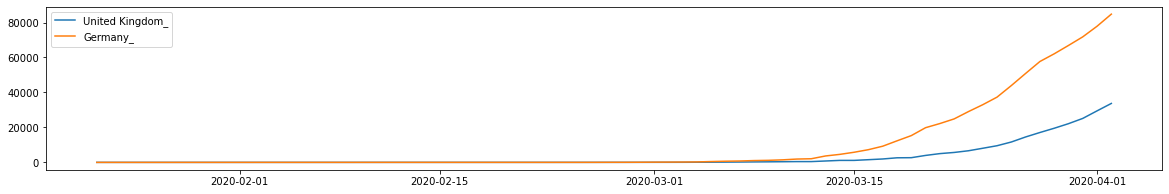

In [14]:
df = pd.read_csv(
    "https://autogluon.s3-us-west-2.amazonaws.com/datasets/CovidTimeSeries/train.csv",
    parse_dates=["Date"],
)

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="name",
    timestamp_column="Date",
)

plt.figure(figsize=(20, 3))
for country in ["United Kingdom_", "Germany_"]:
    plt.plot(train_data.loc[country], label=country)
plt.legend()

In [15]:
train_data.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 22536 entries, ('Afghanistan_', Timestamp('2020-01-22 00:00:00')) to ('Zimbabwe_', Timestamp('2020-04-02 00:00:00'))
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ConfirmedCases  22536 non-null  float64
dtypes: float64(1)
memory usage: 255.4+ KB


In [16]:
train_data.head()

ConfirmedCases
item_id      timestamp                 
Afghanistan_ 2020-01-22             0.0
             2020-01-23             0.0
             2020-01-24             0.0
             2020-01-25             0.0
             2020-01-26             0.0

In [17]:
train_data.loc['Afghanistan_'].head()

,ConfirmedCases
timestamp,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


In [18]:
prediction_length = 5

test_data = train_data.copy()  # the full data set

# the data set with the last prediction_length time steps included, i.e., akin to `a[:-5]`
train_data = train_data.slice_by_timestep(slice(None, -prediction_length))

In [24]:
predictor = TimeSeriesPredictor(
    path="autogluon-covidforecast",
    target="ConfirmedCases",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor.fit(
    train_data=train_data,
    presets="medium_quality",  # "low_quality_hpo", low_quality", "medium_quality", "good_quality", "high_quality", "best_quality"
)

Learner random seed set to 0
presets is set to medium_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'prediction_length': 5,
 'target_column': 'ConfirmedCases',
 'time_limit': None}
Provided training data set with 20971 rows, 313 items. Average time series length is 67.0.
Training artifacts will be saved to: /home/ec2-user/SageMaker/gluonts_sagemaker/autogluon-covidforecast
Validation data is None, will hold the last prediction_length 5 time steps out to use as validation set.
AutoGluon will save models to autogluon-covidforecast/

Starting training. Start time is 2022-06-27 07:35:37
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'MQCNN', 'MQRNN', 'Transformer']
Training timeseries model AutoETS. 
	-0.3287       = Validation score (-MAPE)
	4.21    s     = Tra

Early stopping based on learning rate scheduler callback (min_lr was reached).


	-0.2605       = Validation score (-MAPE)
	204.60  s     = Training runtime
	2.87    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	-0.1964       = Validation score (-MAPE)
	185.93  s     = Training runtime
	31.40   s     = Validation (prediction) runtime
Training complete. Models trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'MQCNN', 'MQRNN', 'Transformer', 'WeightedEnsemble']
Total runtime: 1320.86 s
Best model: WeightedEnsemble
Best model score: -0.1964


In [25]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data


,model,score_test,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.132393,-0.196381,31.404321,185.926131,7
1,SimpleFeedForward,-0.155316,-0.202819,1.708223,140.144257,2
2,DeepAR,-0.173370,-0.215999,2.786230,281.057530,3
3,Transformer,-0.178404,-0.260493,2.867649,204.598310,6
4,MQCNN,-0.222647,-0.295658,1.866202,211.994022,4
5,AutoETS,-0.247532,-0.328701,26.909868,4.209275,1
6,MQRNN,-0.281149,-0.278653,1.670025,218.858180,5


In [26]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data


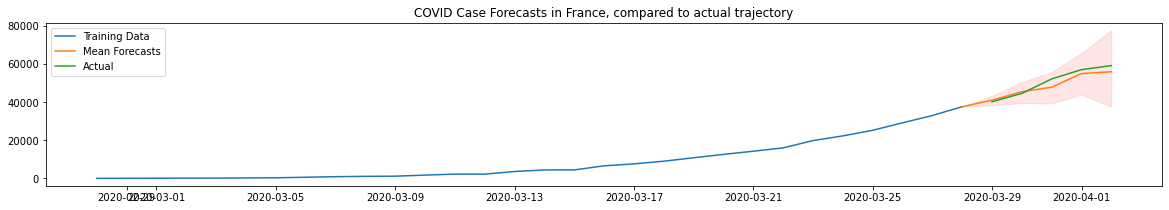

In [27]:
plt.figure(figsize=(20, 3))

ytrue = train_data.loc['France_']["ConfirmedCases"]
ypred = predictions.loc['France_']

# prepend the last value of true range to predicted range for plotting continuity
ypred.loc[ytrue.index[-1]] = [ytrue[-1]] * 10
ypred = ypred.sort_index()

ytrue_test = test_data.loc['France_']["ConfirmedCases"][-5:]

plt.plot(ytrue[-30:], label="Training Data")
plt.plot(ypred["mean"], label="Mean Forecasts")
plt.plot(ytrue_test, label="Actual")

plt.fill_between(
    ypred.index, ypred["0.1"], ypred["0.9"], color="red", alpha=0.1
)
plt.title("COVID Case Forecasts in France, compared to actual trajectory")
_ = plt.legend()